# Tutorial on Helpers for Model Fitting

This tutorial discusses helper codes you can use for model fitting with tellurium. The tutorial gives practical examples of to use these codes in a model fitting workflow.

The utilities are in 3 python modules (files):

- named_timeseries defines a NamedTimeseries type that allows you to manipulate tabular data that has a time axis. A NamedTimeseries can be initialized from a comma separated variable (CSV) file.
- model_fitter defines a ModelFitter type that encapsulates the basics of fitting parameters to a NamedTimeseries. You can simulate the fitted model, and the result is a NamedTimeseries.
- timeseries_plotter plots one or two NamedTimeseries. You can have all variables on a single subplot or have separate subplots for each variable.

In [1]:
import numpy as np
import tellurium as te

from named_timeseries import NamedTimeseries, TIME
from timeseries_plotter import TimeseriesPlotter, PlotOptions
from model_fitter import ModelFitter


## Manipulating Tabular Data
Tables are a great way to describe data. Tables are a collection of values organized into rows and columns. Typically, the columns have names. Common operations on tables are:

- Create a table from a file
- Create a new table from a subset of rows and/or columns
- Create new columns and/rows by performing addition, subtaction, and other operations on table rows and columns.

Many systems provide table representations. Spreadsheets are widely used. In the R language, a dataframe is a table. In python, the pandas package provides a python version of dataframes.

Pandas is very powerful, but it is slow. numpy provides arrays and matrices, but these lack the convenience of column names. In addition, the variables we analyze are collected at the same timepoints, and so it's important to associate these timepoints with the variable values.

``NamedTimeseries`` is a thin layer on top of numpy ``ndarray`` that provides an efficient table abstraction. Efficiency is a particular concern for model fitting since fitting can be very numerically intensive.

Let's start by creating a ``NamedTimeseries`` from the file ``tst_data.txt``. In python, an object is created from a constructor that is the class name followed by arguments. There are several constructors for ``NamedTimeseries``.

In [2]:
ts1 = NamedTimeseries(csv_path="tst_data.txt")  # Construct from a file
print(ts1)

             S1      S2      S3      S4      S5      S6
time                                                   
0.0000   9.9639  0.0245  0.2788  0.6869  0.2543  0.8066
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328
0.8276   3.8228  3.3404  1.2123  1.7698  1.5003  1.0749
0.9655   4.6108  1.7214  1.6500  1.0085  0.1968  1.7338
1.1034   3.5587  1.8193  1.2961  1.2860  0.2940  1.6741
1.2414   2.6042  2.4365  2.5273  2.5676  0.6165  0.7777
1.3793   2.6670  1.2691  2.0335  2.2550  0.8024  2.8139
1.5172   1.2771  1.3716  0.7828  0.9520  1.0949  2.5456
1.6552   2.7374  1.8548  0.7135  0.6904  0.3783  4.0125
1.7931   1.3202  0.6774  2.8310  1.9432  0.7798  5.0623
1.9310   1.7973  0.8914  2.6131  1.0384  0.5163  3.3272
2.0690   1.2621  0.0490  0.7817  1.4685  0.2633 

There are 7 columns (including "time") and 30 rows. All ``NamedTimeseries`` have a "time" column. In fact, the python variable ``TIME`` can be used to reference this column.

We reference rows by their "index", their count from 0. In fact, we can make a new ``NamedTimeseries`` that consists of a subset of the rows.

In [3]:
# Get the first row
print(ts1[1])

            S1      S2      S3      S4      S5    S6
time                                                
0.1379  10.143  1.1243  1.1493  0.7275  0.2183  1.33


In [4]:
# Get rows 1, 3, 5
print(ts1[[1, 3, 5]])

             S1      S2      S3      S4      S5      S6
time                                                   
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328


In [5]:
# Get rows 1 through 5
# This is a slice; you specify the first row you want and where the slice stops
ts2 = ts1[1:6]
print(ts2)

             S1      S2      S3      S4      S5      S6
time                                                   
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328


We can also select columns. A column select produces a ``numpy`` ``ndarray``, not at ``NamedArray``. This is done so that we can manipulate column selections using the powerful numpy facilities.

In [6]:
# Get S1
ts2["S1"]

array([10.143 ,  6.9845,  7.3271,  7.0252,  6.084 ])

In [7]:
# Get S1 and S2
ts2[["S1", "S2"]]  # Index by a list of column names

array([[10.143 ,  1.1243],
       [ 6.9845,  2.426 ],
       [ 7.3271,  2.4685],
       [ 7.0252,  1.8382],
       [ 6.084 ,  2.7645]])

To create a new ``NamedTimeseries`` from ``ts2[["S1", "S2"]]``, we make use of an alternative constructor for ``NamedTimeseries``.

In [8]:
# This fails because we forgot to include the "time" column
#ts3 = NamedTimeseries(colnames=["S1", "S2"], array=ts2[[ "S1", "S2"]])

In [9]:
ts3 = NamedTimeseries(colnames=[TIME, "S1", "S2"], array=ts2[[TIME, "S1", "S2"]])
print(ts3)

             S1      S2
time                   
0.1379  10.1430  1.1243
0.2759   6.9845  2.4260
0.4138   7.3271  2.4685
0.5517   7.0252  1.8382
0.6897   6.0840  2.7645


We can also do calculations and create new columns with the results.

In [10]:
ts3["New_Calculation"] = ts3["S1"] + np.multiply(ts3["S2"], ts3[TIME])
ts3["Other_Calculation"] = ts3["S1"] + 10*np.multiply(ts3["S2"], ts3[TIME])
print(ts3)

             S1      S2  New_Calculation  Other_Calculation
time                                                       
0.1379  10.1430  1.1243        10.298041          11.693410
0.2759   6.9845  2.4260         7.653833          13.677834
0.4138   7.3271  2.4685         8.348565          17.541753
0.5517   7.0252  1.8382         8.039335          17.166549
0.6897   6.0840  2.7645         7.990676          25.150756


In [11]:
# Let's get rid of Other_Calculation
del ts3["Other_Calculation"]
print(ts3)

             S1      S2  New_Calculation
time                                    
0.1379  10.1430  1.1243        10.298041
0.2759   6.9845  2.4260         7.653833
0.4138   7.3271  2.4685         8.348565
0.5517   7.0252  1.8382         8.039335
0.6897   6.0840  2.7645         7.990676


In [12]:
# Save the result in a file
ts3.to_csv("new_data.csv")

In [13]:
# To see the file, we run a command in the operating system shell. The following works in Unix and Mac.
!cat new_data.csv

time,S1,S2,New_Calculation
0.1379,10.143,1.1243,10.29804097
0.2759,6.9845,2.426,7.6538334
0.4138,7.3271,2.4685,8.3485653
0.5517,7.0252,1.8382,8.03933494
0.6897,6.084,2.7645,7.99067565


## Plotting Tabular Data
We provide 4 types of plots with user controllable options for the plots. The plots are:

1. Plot all variables of one table on a single plot.
1. Plot all variables of one table in one plot and all variables of second plot
1. Plot each variable of a table in a separate plot
1.  Plot each variable of two tables in the same plot

In [14]:
# Create the plotter object
plotter = TimeseriesPlotter(ts1)

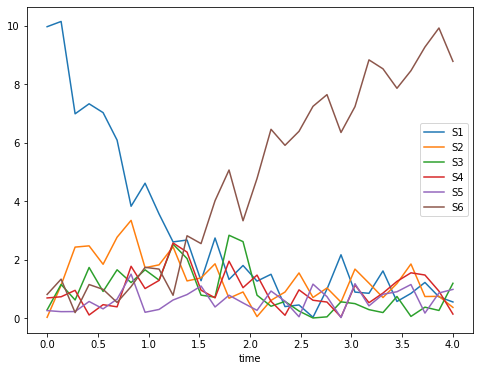

In [15]:
# Case 1: Plot all variables of a single table on a single plot
plotter.plotMultiple()

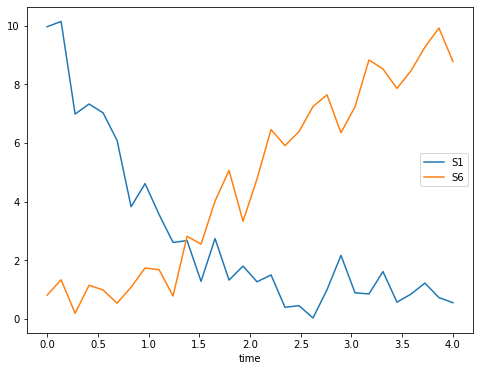

In [16]:
# We can also plot a subset of the variables in a single plot
plotter.plotMultiple(variables=["S1", "S6"])

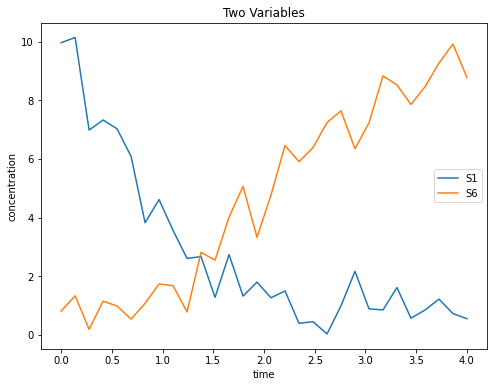

In [17]:
# Add to the plot with options
options = PlotOptions()
options.ylabel = "concentration"
options.title = "Two Variables"
plotter.plotMultiple(variables=["S1", "S6"], options=options)

In [18]:
# Create a second table for comparisons. We can access all non-time variables using the property colnames.
ts4 = ts1.copy()  # Create a copy of the timeseries
ts4[ts4.colnames] = 5*np.cos(ts4[ts4.colnames]) + 2*ts4[ts4.colnames]

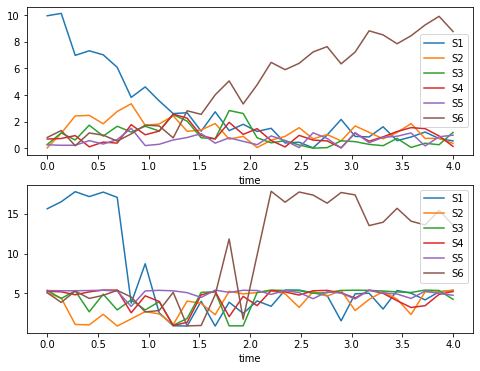

In [19]:
# Case 2: Plot two multiple variable plots, side-by-side
plotter.plotMultiple(timeseries2=ts4)

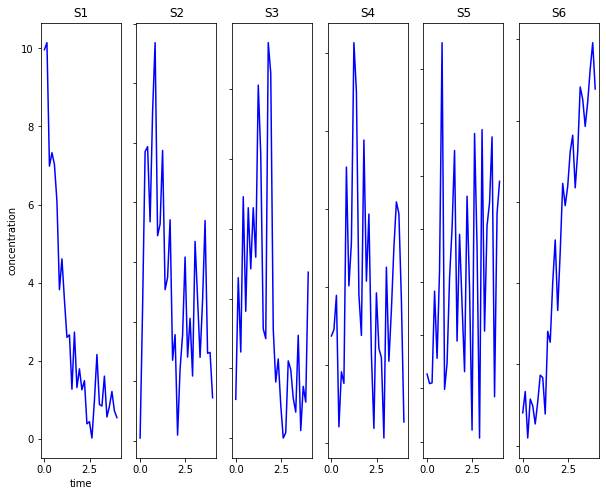

In [20]:
# Case 3: Separate plot for each variable of a single table
options = PlotOptions()
options.figsize = (10, 8)
plotter.plotSingle(options=options)

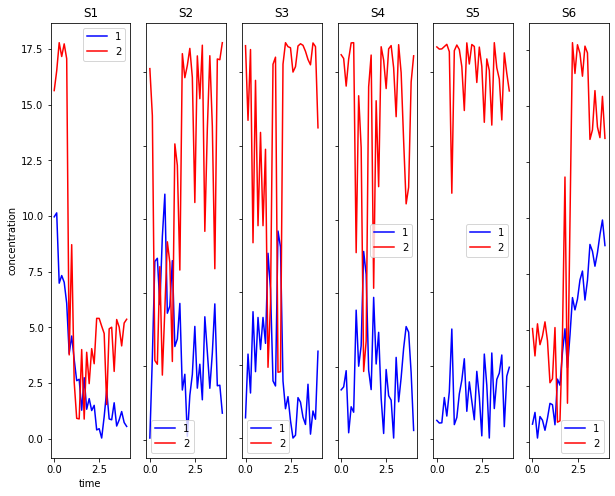

In [21]:
# Case 4: Separate plot for each variable for two tables
options = PlotOptions()
options.figsize = (10, 8)
plotter.plotSingle(options=options, timeseries2=ts4)

## Fitting Parameters of a Model
Kinetics models frequently have unknown constants that need to be estimated. This process of estimation is called model fitting, or just fitting. Fitting involves running multiple simulations with different values of parameters to find values that result in a good match between simulated and measured species concentrations.

In [22]:
ANTIMONY_MODEL = """ 
# Reactions   
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    J3: S3 -> S4; k3*S3
    J4: S4 -> S5; k4*S4
    J5: S5 -> S6; k5*S5;
# Species initializations
    S1 = 10;
    S2 = 0;
    S3 = 0;
    S4 = 0;
    S5 = 0;
    S6 = 0;
    k1 = 1;
    k2 = 2;
    k3 = 3;
    k4 = 4;
    k5 = 5;
"""

This model has the parameters ``k1, k2, k3, k4, k5``, the kinetics constants for their respective reactions. In this case, we know the true value of the parameters, which are specified at the bottom of the model. This knowledge provides a way to explore the effectiveness of model fitting.

This model is a linear pathway where mass moves from species ``S1`` to ``S6`` over time. The rate at which this happens depends on the kinetics constants.

Let's see how well we can fit this model to the ``ts1`` data described in the first section.

In [23]:
print(ts1)

             S1      S2      S3      S4      S5      S6
time                                                   
0.0000   9.9639  0.0245  0.2788  0.6869  0.2543  0.8066
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328
0.8276   3.8228  3.3404  1.2123  1.7698  1.5003  1.0749
0.9655   4.6108  1.7214  1.6500  1.0085  0.1968  1.7338
1.1034   3.5587  1.8193  1.2961  1.2860  0.2940  1.6741
1.2414   2.6042  2.4365  2.5273  2.5676  0.6165  0.7777
1.3793   2.6670  1.2691  2.0335  2.2550  0.8024  2.8139
1.5172   1.2771  1.3716  0.7828  0.9520  1.0949  2.5456
1.6552   2.7374  1.8548  0.7135  0.6904  0.3783  4.0125
1.7931   1.3202  0.6774  2.8310  1.9432  0.7798  5.0623
1.9310   1.7973  0.8914  2.6131  1.0384  0.5163  3.3272
2.0690   1.2621  0.0490  0.7817  1.4685  0.2633 

The fitting data has values for each of the six floating species. Model fitting works iteratively varying the values of the parameters, simulating the model with these parameters, and then evaluating how close the simulation is to the fitting data.

So, to do a fit, we must specify:

1. The model to fit
1. The fitting data
1. The parameters to estimate

To elaborate on point (3), often models contain some parameters whose values are known and others that aren't.

The class ``ModelFitter`` is used to do fitting. The constructor must specify all 3 items above.

In [24]:
# Example of fitting
parameter_names = ["k1", "k2", "k3", "k4", "k5"]
base_fitter = ModelFitter(ANTIMONY_MODEL, ts1, parameter_names)

The fitter object contains some interesting information.

In [25]:
# Information from constructor
print("Roadrunner model for the antimony model provided: %s" % str(base_fitter.roadrunner_model))
print("Parameters specified in the constructor: %s" % str(base_fitter.parameters_to_fit))
print("Data provided for fitting: \n%s" % str(base_fitter.timeseries))

Roadrunner model for the antimony model provided: <roadrunner.RoadRunner() { 
'this' : 0x5651a235b900
'modelLoaded' : true
'modelName' : 
'libSBMLVersion' : LibSBML Version: 5.17.2
'jacobianStepSize' : 1e-05
'conservedMoietyAnalysis' : false
'simulateOptions' : 
< roadrunner.SimulateOptions() 
{ 
'this' : 0x56519ff066d0, 
'reset' : 0,
'structuredResult' : 0,
'copyResult' : 1,
'steps' : 50,
'start' : 0,
'duration' : 4
}>, 
'integrator' : 
< roadrunner.Integrator() >
  name: cvode
  settings:
      relative_tolerance: 0.000001
      absolute_tolerance: 0.000000000001
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: false

}>
Parameters specified in the constructor: ['k1', 'k2', 'k3', 'k4', 'k5']
Data provided for fitting: 
             S1      S2      S3      S4      S5      S6


The quality of fitting is measured by the difference between the values of floating species in the fitting data and their values produced by the simulation with fitted values. This difference is called the **residuals**. The residuals are a vector of floating point numbers. The variance of the residuals provides a single score. Of course, a lower value is better.

In [26]:
# Other useful information in fitter
print("Variance of residuals for unfitted model: %3.2f" % base_fitter.unoptimized_residual_variance)

Variance of residuals for unfitted model: 0.36


To fit a model, we use the ``fitModel`` method. We can then see the optimized residual variance and the values of the model parameters.

We can construct simulation data by making use of the roadrunner model created by fitter and running a simulation that uses the start and end times of the fitting data.

In [27]:
model = base_fitter.roadrunner_model
model.reset()  # Restart the simulation at time 0
sim_ts = NamedTimeseries(named_array=model.simulate(ts1.start, ts1.end, len(ts1)))
print(sim_ts)


                 S1        S2        S3        S4        S5        S6
time                                                                 
0.000000  10.000000  0.000000  0.000000  0.000000  0.000000  0.000000
0.137931   8.711588  1.122412  0.144613  0.018632  0.002401  0.000355
0.275862   7.589176  1.829617  0.441088  0.106339  0.025636  0.008144
0.413793   6.611377  2.240346  0.759169  0.257254  0.087174  0.044680
0.551724   5.759559  2.442307  1.035646  0.439159  0.186223  0.137106
0.689655   5.017491  2.499969  1.245613  0.620627  0.309228  0.307073
0.827586   4.371031  2.460440  1.384974  0.779597  0.438833  0.565125
0.965517   3.807862  2.357880  1.460033  0.904072  0.559813  0.910339
1.103448   3.317252  2.216835  1.481457  0.990020  0.661604  1.332831
1.241379   2.889853  2.054728  1.460943  1.038752  0.738567  1.817157
1.379310   2.517521  1.883729  1.409498  1.054654  0.789142  2.345456
1.517241   2.193161  1.712165  1.336660  1.043510  0.814651  2.899853
1.655172   1.910591 

Let's make use of the plotting capabilities. Since we have a ``NamedTimeseries`` for both the fitting data and the simulation data, we can make use of ``TimeseriesPlotter``.

In [28]:
plotter = TimeseriesPlotter(ts1)

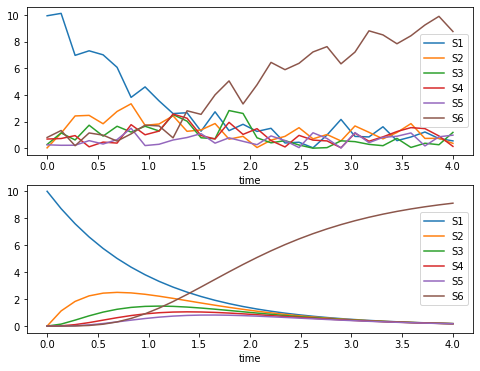

In [29]:
base_model = base_fitter.roadrunner_model
base_model.reset()
base_ts = NamedTimeseries(named_array=base_model.simulate(ts1.start, ts1.end, len(ts1)))
plotter.plotMultiple(timeseries2=base_ts)

This is a bit crowded for detailed comparisons. So, we make comparisons between each variable.

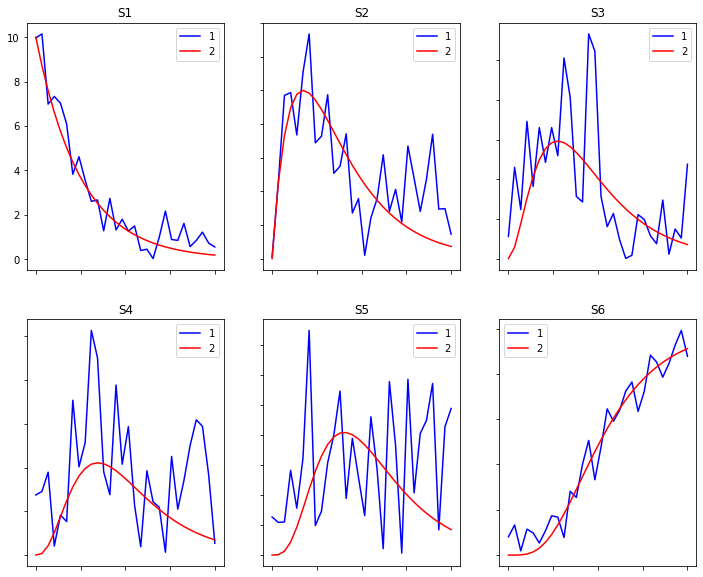

In [30]:
options = PlotOptions()
options.figsize = (12, 10)  # Fiigure size in width by length
plotter.plotSingle(timeseries2=base_ts, num_row=2, num_col=3, options=options)

In our running example, the values of parameters in the original model are their true value. Ideally, we want to achieve a variance close to this. We create a new fitter object since we still want to have access to the unchanged model that we started with.

In [31]:
fitter = ModelFitter(ANTIMONY_MODEL, ts1, parameter_names)
fitter.fitModel()
print("residual variance of the fitted model: %3.2f" % fitter.optimized_residual_variance)
print("Values of fitted parameters: %s" % str(fitter.getFittedParameters()))

residual variance of the fitted model: 0.35
Values of fitted parameters: [0.9557796515913075, 2.240771580598564, 2.9677115464981254, 3.0765890709471497, 5.907197874353374]


Now let's compare the fitted model with the data.

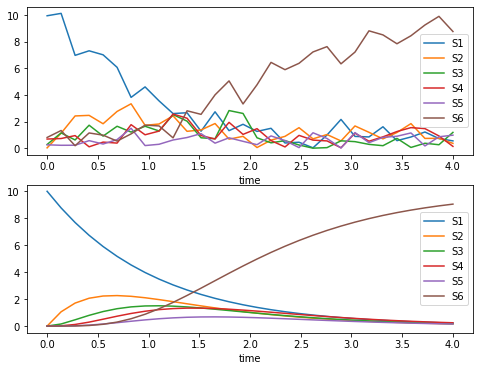

In [32]:
fitted_model = fitter.roadrunner_model
fitted_model.reset()
fitted_ts = NamedTimeseries(named_array=fitted_model.simulate(ts1.start, ts1.end, len(ts1)))
plotter.plotMultiple(timeseries2=fitted_ts)

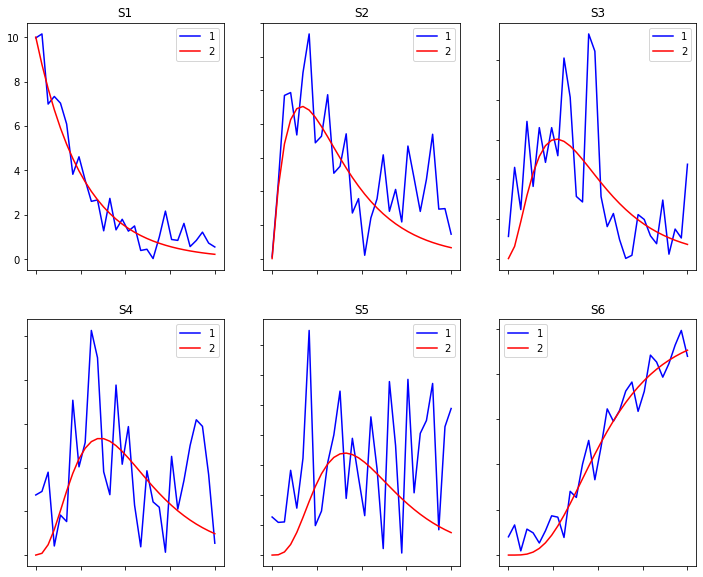

In [33]:
options = PlotOptions()
options.figsize = (12, 10)  # Fiigure size in width by length
plotter.plotSingle(timeseries2=fitted_ts, num_row=2, num_col=3, options=options)

Since these plots look very similar to the what we got with the base simulation with its orginal values, we compare the base with the fitted values.

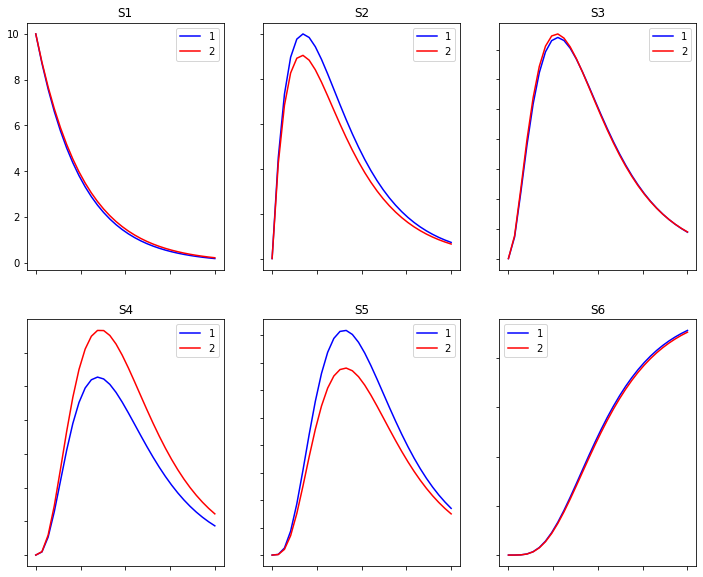

In [34]:
options = PlotOptions()
options.figsize = (12, 10)  # Fiigure size in width by length
plotter = TimeseriesPlotter(base_ts)
plotter.plotSingle(timeseries2=fitted_ts, num_row=2, num_col=3, options=options)

To understand deviations here, let' return to the fitted values and contrast them with the "ground truth". We see that ``k1, k3, k5`` are quite close to "ground truth", but this is not the case for ``k2, k4``.

In [35]:
fitter.getFittedParameters()

[0.9557796515913075,
 2.240771580598564,
 2.9677115464981254,
 3.0765890709471497,
 5.907197874353374]